# _Word2Vec Model_

(The notebook follows along with [this](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) tutorial on gensim's website.)

This notebook introduces the [`gensim`](https://radimrehurek.com/gensim/index.html) library, which can be used for various NLP tasks, with a specific focus on topic modeling. 

More specifically, this notebook will follow along with `gensim`'s [Word2Vec Model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) tutorial, which gives the user hands-on experience not only with the library but with [`Word2Vec`](https://en.wikipedia.org/wiki/Word2vec) as well, which is an algorithm used to learn a word embedding from a text corpus.

What `Word2vec` does is take large amounts of unannotated text and attempts to learn the semantic relationships between the words. The outputs are vectors, with one vector per word. For example, it allows us to detect the following relationships:
- vec("king") - vec("man") + vec("woman") =~ vec("queen")
- vec("Montral Canadiens") - vec("Montreal") + vec("Toronto") =~ vec("Toronto Maple Leafs")

Now how does it do this? How is it capable of detecting these relationships? It uses a neural network to embed words in a lower-dimensional vector space. The result is a set of word-vectors that cluster together according to their meanings. In other words, words that are grouped together have similar meanings, while words that are further away from each other are more dissimilar. 

There are two versions of `Word2vec`, and the `gensim` class implements them both:
1. Skip-grams (SG)
2. Continuous-bag-of-words (CBOW)

Skip-grams takes in a pair of words generated by a moving window across the text data. It trains a 1-hidden-layer neural network based on this, resulting in a predicted probability distribution of words that are nearby to the input (i.e. the first word). Then a virtual one-hot encoding of words goes through a 'project layer' to the hidden layer, and these projection weights are later interpreted as word embeddings. 

Continuous-bag-of-words is similar in that it also has a 1-hidden-layer neural network. Instead of using a single word as in skip-gram, the training task now uses the average of multiple input context words to predict the center word. Then the projection weights are again turned from one-hot words into averageable vectors, of the same width as the hidden layer, and interpreted as the word embeddings.

### _Demo_

We are going to download a pre-trained model and play around with it. We'll use `gensim` to fetch the `Word2Vec` model trained on part of the Google News dataset, which covers approximately 3 million words and phrases. Training such a model can take hours, but this one is already available and all we have to do is download it. 

In [18]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import gensim.downloader as api

In [3]:
# load in word2vec trained on Google News
wv = api.load('word2vec-google-news-300')

In [4]:
# let's retrieve some of the vocabulary of the model
for i, word in enumerate(wv.vocab):
    if i == 10:
        break
    print(word)

</s>
in
for
that
is
on
##
The
with
said


In [5]:
# we can easily obtain vectors for terms the model is familiar with
vec_king = wv['king']

In [6]:
# however, it is unable to infer vectors for unfamilar words
try:
    vec_cameroon = wv['cameroon']
except KeyError:
    print('The word cameroon does not appear in this mode.')

The word cameroon does not appear in this mode.


In [7]:
# Word2Vec supports several word similarities out of the box
pairs = [
    ('car', 'minivan'),
    ('car', 'bicycle'),
    ('car', 'airplane'),
    ('car', 'cereal'),
    ('car', 'communism')
]

for w1, w2 in pairs:
    print(f'{w1} : {w2} --> {wv.similarity(w1, w2)}')

car : minivan --> 0.6907036304473877
car : bicycle --> 0.5364484786987305
car : airplane --> 0.42435577511787415
car : cereal --> 0.13924746215343475
car : communism --> 0.05820293724536896


Let's take a second to assess what just happened. We took a list of tuples containing the word `car` and a miscellaneous word. Some of these miscellaneous words were more similar to `car`, like `minivan`. Other words had next to nothing to do with `car`, i.e. `communism`. 

When we look at there similarity scores, we can see a trend. The less similar the word is to `car`, the lower the score is. So, remember that vector space we talked about before? That number essentially represents how close that respective word is to `car`. The higher the value, the closer it is; the lower the value, the further away the word is.

In [2]:
# we can even see which are the 5 most similar words to car or minivan
# print(wv.most_similar(positive=['car', 'minivan'], topn=5))
# the above line takes too much time on my local machine; if your
# machine has a significant amount of memory, you can uncomment the line above
# and run this command

## _Training Your Own Model_

In addition to pre-trained models like the Google News one above, we can create our own model as well. First, we'll need some data. Gensim includes some data sets, including the [Lee Corpus](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/test/test_data/lee_background.cor), which we'll use to train our first model. 

This corpus is smaller than Google News, however, we'll implement a memory-friendly iterator that reads it in line-by-line, which is a better demonstration of how to handle a larger corpus.

The `MyCorpus` class also gives us the capability, if we so choose, to do custom preprocessing. For example, we could decode a non-standard encoding, or lowercase the text, extract named entities, etc. All of this could be done inside the `MyCorpus` iterator.

In [2]:
from gensim.test.utils import datapath
from gensim import utils

In [3]:
class MyCorpus(object):
    '''An iterator that yields sentences (lists of str)'''
    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            #assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [4]:
# train an out-of-the-box model on the Lee corpus
import gensim.models

sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

We now have our model, and we can use this in the same way to the Google model above. The main part of the model is `model.wv`, where `wv` stands for **"word vectors"**.

In [5]:
# get vector for word king
vec_king = model.wv['king']

In [6]:
# retrieve the vocabulary of our model
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

hundreds
of
people
have
been
forced
to
their
homes
in


## _Storing and loading models_

There is an unfortunate downside to training models: they can take significant amounts of time. Once your model has been trained and it works (like you expect it to), you can save it to disk. This means that we won't have to spend time training it again!

In [7]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # the model can now safely be stored in the filepath
    # you can copy it to other machines, share it with others, etc
    #
    # To laod a saved model
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

This uses pickle internally. In addition, you can load models created by the original C tool, both using its text and binary formats.

## _Training Parameters_

`Word2Vec` accepts several parameters that affect both training speed and quality.

### `min_count`

This is for pruning the internal dictionary. Words that appear only a few times in say, a billion-word corpus, are uninteresting. Plus, there's not enough data to make anything useful of them, so it's best to ignore them. 

The default value of `min_count` is 5.

In [8]:
# with our corpus, create model where a word has to appear at least 10 times
model = gensim.models.Word2Vec(sentences, min_count=10)

### `size`

This is the number of dimensions $N$ of the $N$-dimensional space that `gensim` Word2Vec maps the words onto. A bigger size value requires more training data, but can lead to better (i.e. more accurate) models. For a start, values within the tens to the hundreds are reasonable.

In [9]:
# set the size of N equal to 200 (default = 100)
model = gensim.models.Word2Vec(sentences, size=200)

### `workers`

This is the last major parameter, and is for parallelization, which speeds up training. The default number of `workers` is equal to 3. 

If you want a full list of parameters, you can check out this [link](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

In [10]:
# set number of workers equal to 4 (default = 3)
model = gensim.models.Word2Vec(sentences, workers=4)

## _Memory_

`Word2Vec` models are stored as matrices (i.e. `NumPy` arrays) with each array being **vocabulary times size of floats**. Three matrices are held in RAM, so if your input contains 100,000 unique words, and has `size=200`, the model will require approximately `100,000 * 200 * 4 * 3 = ~229MB`. 

Additionally, there's a little extra memory needed for storing the vocabulary tree (which requires a few megabytes) but unless your words are extremely long strings, the footprint of this will be minimal compared to the three matrices above. 

## _Evaluating_

Since `Word2Vec` is an unsupervised task, there's no "good" way to evaluate the result, as evaluation is also dependent on your end application. 

Google has released their testing set of 20,000 syntactic & semantic test examples that follow the __"A is to B as C is to D"__ task; this is provided in the `datasets` folder. 

An example of a syntactic analogy is `bad to words : good to ?`. There are a total of 9 types of syntactic comparisons in the dataset like plural nouns and nouns of opposite meaning.

An example of a semantic question could be capital cities (`Paris to France : Tokyo to ?`) or family members (`brother to sister : dad to ?`). There are five types of these semantic analogies.

In [11]:
# you can access the Google test examples with the following command 
# model.accuracy('/datasets/questions-words.txt')
# throws a FileNotFoundError, need to address this

## _Online training/Resuming Training_

A more advanced technique is to load a model and continue training it with more sentences and new vocabulary words.

In [12]:
model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)

/opt/conda/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


(28, 65)

In [13]:
# clean up temporary file
import os
os.remove(temporary_filepath)

## _Training Loss Computation_

There is a parameter -- `compute_loss` -- that can be used to toggle computation of loss while training the `Word2Vec` model, which is stored in the model attribute `running_training_loss`. This can be retrieved using the function `get_latest_training_loss` as follows:

In [14]:
# instantiate and train the Word2Vec model
model_with_loss = gensim.models.Word2Vec(
    sentences,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42
)

# get the training loss value
training_loss = model_with_loss.get_latest_training_loss()
print(training_loss)

1366818.125


## _Benchmarks_

We'll now run some benchmarks to see the effect of the training loss computation code on training time. We'll use the following data for these benchmarks:
1. Lee Background corpus
2. Text8 corpus (of which we'll use a corpus size of 1MB, 10MB, 50MB, and the entire thing to show the effect of corpus size)

In [17]:
import io
import os

import gensim.models.word2vec
import gensim.downloader as api
import smart_open

def head(path, size):
    with smart_open.open(path) as fin:
        return io.StringIO(fin.read(size))
    

def generate_input_data():
    lee_path = datapath('lee_background.cor')
    ls = gensim.models.word2vec.LineSentence(lee_path)
    ls.name = '25kB'
    yield ls
    
    text8_path = api.load('text8').fn
    labels = ('1MB', '10MB', '50MB', '100MB')
    sizes = (1024 ** 2, 10 * 1024 ** 2, 50 * 1024 ** 2, 100 * 1024 ** 2)
    for l, s in zip(labels, sizes):
        ls = gensim.models.word2vec.LineSentence(head(text8_path, s))
        ls.name = l
        yield ls
        
        
input_data = list(generate_input_data())

In [19]:
# reduces logging verbosity
logging.root.level = logging.ERROR

import time 
import numpy as np
import pandas as pd

train_time_values = []
seed_val = 42
sg_values = [0, 1]
hs_values = [0, 1]

fast = True
if fast:
    input_data_subset = input_data[:3]
else:
    input_data_subset = input_data
    
for data in input_data_subset:
    for sg_val in sg_values:
        for hs_val in hs_values:
            for loss_flag in [True, False]:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = gensim.models.Word2Vec(
                        data,
                        compute_loss=loss_flag,
                        sg=sg_val,
                        hs=hs_val,
                        seed=seed_val
                    )
                    time_taken_list.append(time.time() - start_time)
                    
                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)
                
                model_result = {
                    'train_data': data.name,
                    'compute_loss': loss_flag,
                    'sg': sg_val,
                    'hs': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std
                }
                print(f'Word2vec model #{len(train_time_values)}: {model_result}')
                train_time_values.append(model_result)
                
                
train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data', 'sg', 'hs', 'compute_loss'],
    ascending=[False, False, True, False]
)
print(train_times_table)

Word2vec model #0: {'train_data': '25kB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 0.7699283758799235, 'train_time_std': 0.09238672276083387}
Word2vec model #1: {'train_data': '25kB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 1.0060993830362956, 'train_time_std': 0.20686646423759777}
Word2vec model #2: {'train_data': '25kB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 1.0680383841196697, 'train_time_std': 0.06530074163820941}
Word2vec model #3: {'train_data': '25kB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 0.966907819112142, 'train_time_std': 0.04711427786666781}
Word2vec model #4: {'train_data': '25kB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 1.368126392364502, 'train_time_std': 0.16210996682683151}
Word2vec model #5: {'train_data': '25kB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 1.4141527811686199, 'train_time_std': 0.14593519866747173}
Word2vec model #6: {'train_data': '25kB

## _Adding Word2Vec "model to dict" method to production pipeline_

Suppose, we still want more performance improvement in production. One good way is to cache all the similar words in a dictionary so that next time when we get the similar query word, we'll search it first in the dictionary. If it's a hit then we will show the result directly from the dictionary. Otherwise, we will query the word and then cache it so that it doesn't miss next time.

In [22]:
# re-enable logging
logging.root.level = logging.INFO

most_similars_precalc = {word: model.wv.most_similar(word) for word in model.wv.index2word}
for i, (key, value) in enumerate(most_similars_precalc.items()):
    if i == 3:
        break
    print(key, value)
    print()

the [('at', 0.9999333620071411), ('for', 0.9999247193336487), ('an', 0.9999247193336487), ('from', 0.999921977519989), ('first', 0.9999215006828308), ('in', 0.9999207258224487), ('up', 0.9999201893806458), ('which', 0.9999191761016846), ('and', 0.9999188184738159), ('three', 0.9999182820320129)]

to [('from', 0.99994957447052), ('their', 0.9999488592147827), ('or', 0.9999451637268066), ('for', 0.9999425411224365), ('are', 0.9999412894248962), ('up', 0.9999390840530396), ('if', 0.9999351501464844), ('and', 0.9999338984489441), ('on', 0.9999326467514038), ('this', 0.9999306201934814)]

of [('in', 0.9999549984931946), ('with', 0.9999465346336365), ('on', 0.9999427795410156), ('at', 0.9999412298202515), ('by', 0.9999400973320007), ('from', 0.9999397397041321), ('up', 0.9999372959136963), ('after', 0.9999370574951172), ('into', 0.9999359846115112), ('its', 0.9999350309371948)]



## _Comparison with and without caching_

Now, let's take four random words and compare the above, with and without caching.

In [23]:
import time
words = ['voted', 'few', 'their', 'around']

In [24]:
# without caching
start = time.time()
for word in words:
    result = model.wv.most_similar(word)
    print(result, '\n')
end = time.time()
print(end - start)

[('crew', 0.9986211061477661), ('training', 0.9985557794570923), ('responsibility', 0.9985557198524475), ('israel', 0.9985209107398987), ('help', 0.9985154867172241), ('them', 0.9985077381134033), ('expected', 0.9985071420669556), ('when', 0.9984973073005676), ('as', 0.998496413230896), ('yesterday', 0.9984922409057617)] 

[('after', 0.9997555613517761), ('government', 0.9997546672821045), ('world', 0.9997545480728149), ('could', 0.999753475189209), ('two', 0.999751627445221), ('time', 0.9997506141662598), ('where', 0.9997493028640747), ('has', 0.9997479319572449), ('first', 0.9997466802597046), ('at', 0.9997460842132568)] 

[('his', 0.9999548196792603), ('which', 0.9999532103538513), ('from', 0.9999508261680603), ('and', 0.999950110912323), ('are', 0.9999499320983887), ('to', 0.9999488592147827), ('as', 0.9999479651451111), ('has', 0.9999475479125977), ('any', 0.9999461770057678), ('will', 0.999945342540741)] 

[('with', 0.9999159574508667), ('from', 0.9999159574508667), ('on', 0.9999

In [25]:
# with caching
start = time.time()
for word in words:
    if 'voted' in most_similars_precalc:
        result = most_similars_precalc[word]
    else:
        result = model.wv.most_similar(word)
        most_similars_precalc[word] = result
        print(result)
        
end = time.time()
print(end - start)

0.0001468658447265625


Notice the difference in time. Now in this example, the difference is not huge, but this difference will be even larger when we start using more and more words.

## _Visualizing the Word Embeddings_

If we reduce the dimensionality of the words to 2-dimensions, we can visualize the word embeddings, which can be used to pick-up semantic and syntactic trends in the data.

Examples:
- Semantic: word like cat, dog, etc. have a tendency to lie close to each other
- Syntactic: words like run, running or cut, cutting lie close together

In [28]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model):
    num_dimensions = 2 # 2-dimensional
    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)
        
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    
    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)
    
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model)

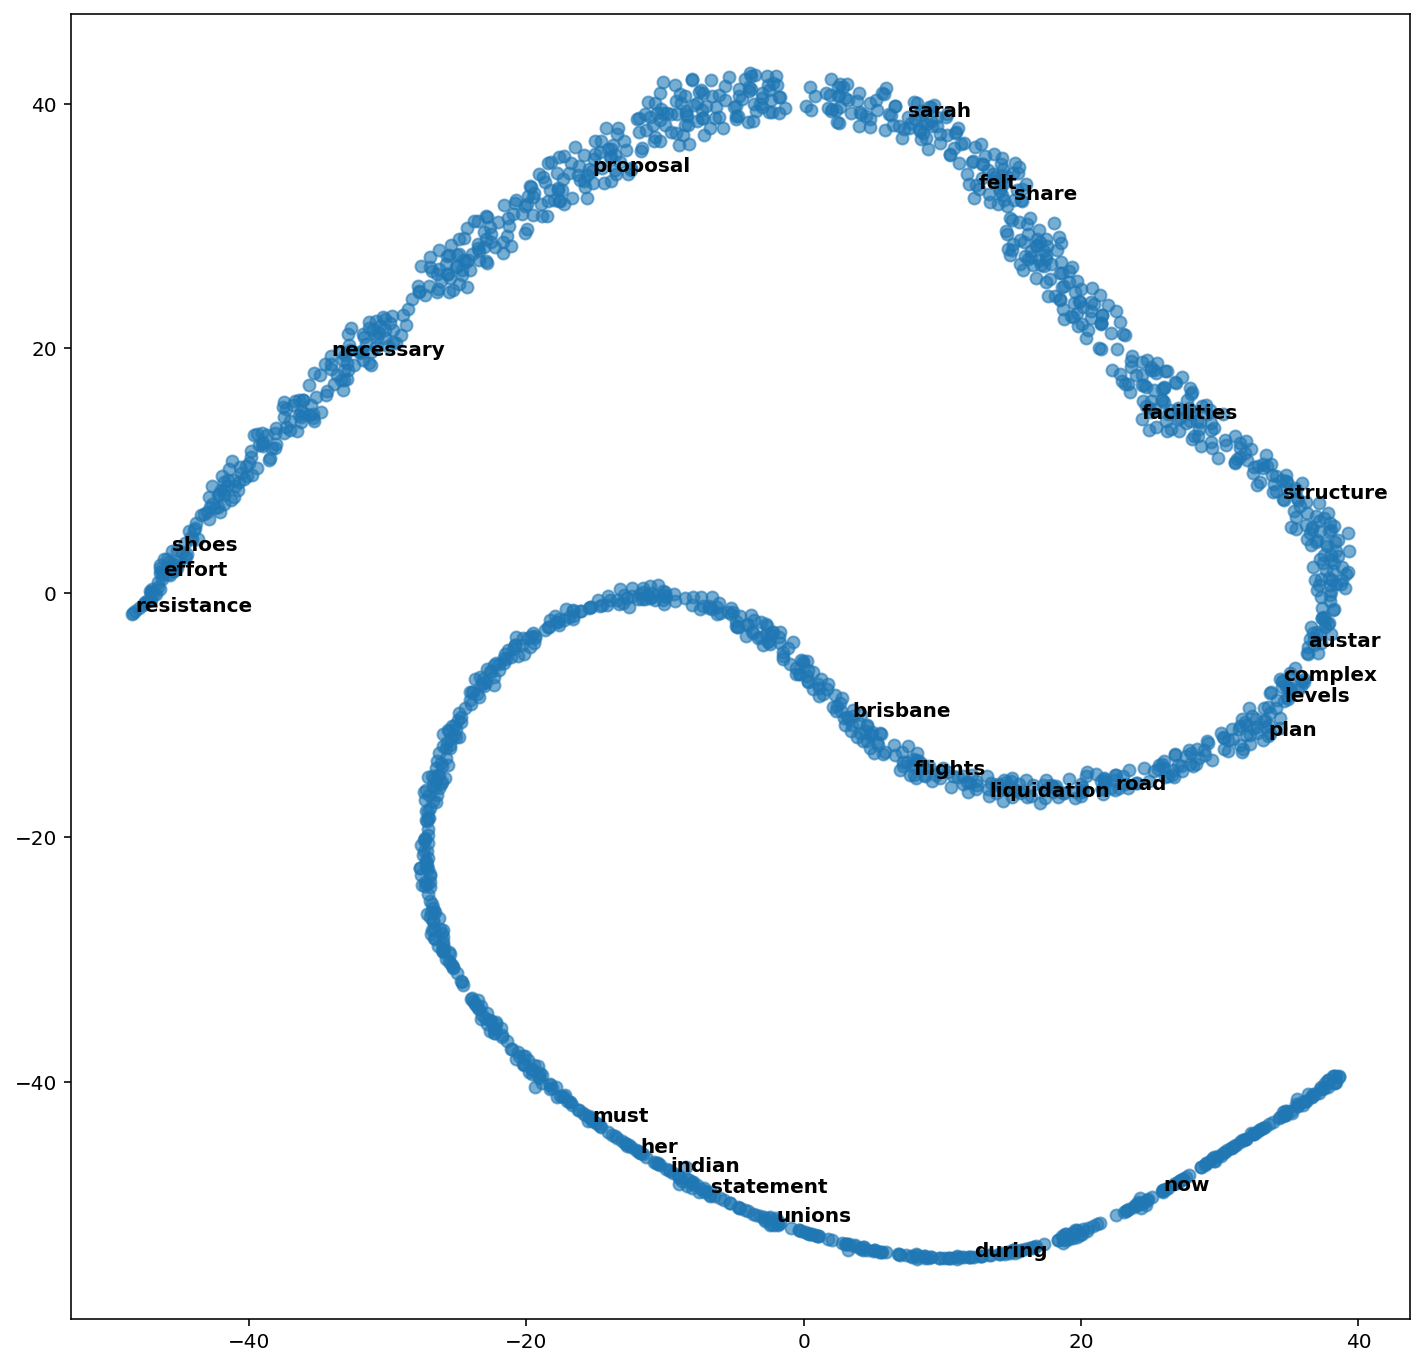

In [38]:
import matplotlib.pyplot as plt
import random

def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(1)
    plt.figure(figsize=(12,12))
    plt.scatter(x_vals, y_vals, alpha=0.6)
    # label randomly subsampled 25 data points
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]), fontweight='bold')
        
plot_with_matplotlib(x_vals, y_vals, labels)